In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import pandas as pd
import numpy as np

import torch
from torch import nn

from torch.optim import Adam

from time import time

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [6]:
from models import estimators

In [7]:
from base import samplers

# Samplers

In [8]:
uniform = samplers.distribution2

In [9]:
gaussian = samplers.distribution3

In [10]:
f = torch.tensor(next(uniform()), dtype=torch.float)

In [11]:
g = torch.tensor(np.concatenate((next(gaussian()), next(gaussian())), axis=1))

In [12]:
f.size()

torch.Size([512, 2])

In [52]:
def generate(n=20):
    
    for _ in range(n):
        
        f = torch.tensor(next(uniform())[:, [0]], dtype=torch.float)
        g = torch.tensor(next(gaussian()), dtype=torch.float)
        
        yield f, g

# Estimators

## Jensen-Shannon

In [163]:
js = estimators.JensenShannon(input_dimension=1)

In [164]:
optimiser = Adam(js.parameters(), lr=.001)

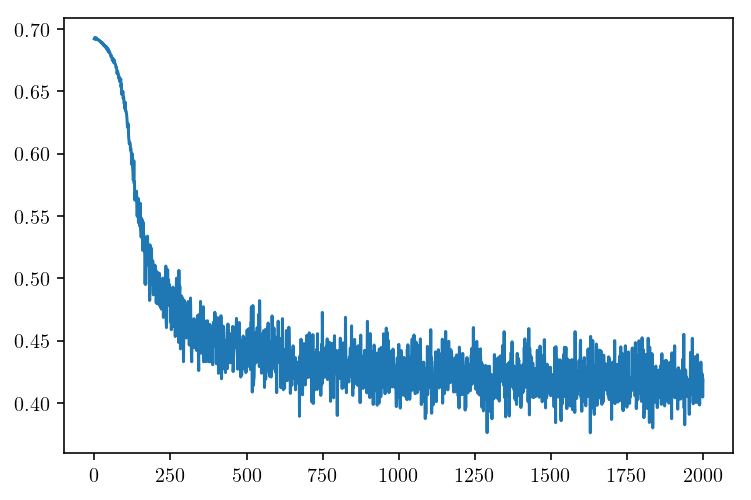

In [165]:
losses = []

for f, g in generate(2000):
    
    js.zero_grad()
    
    loss = js.loss(f, g)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    
losses = np.array(losses)

plt.figure()
plt.plot(losses)
plt.show()

In [143]:
for f, g in generate(100):
    
    js.zero_grad()
    
    loss = js.loss(f, f)
    loss.backward()
    
    optimiser.step()
    
    print(- loss.item())

-0.738460123538971
-0.7414331436157227
-0.7359554767608643
-0.7375761270523071
-0.7381372451782227
-0.7430994510650635
-0.7473765015602112
-0.7307071685791016
-0.7435665130615234
-0.735446572303772
-0.7440869212150574
-0.7413666248321533
-0.7631571292877197
-0.730315625667572
-0.7371313571929932
-0.7322390079498291
-0.7575275897979736
-0.7462890148162842
-0.7292308807373047
-0.7353289723396301
-0.7312805652618408
-0.7406979203224182
-0.731353223323822
-0.7278462648391724
-0.7374575734138489
-0.7369408011436462
-0.7477246522903442
-0.7428696155548096
-0.747680127620697
-0.7331256866455078
-0.7357761263847351
-0.7252187728881836
-0.7381364703178406
-0.7432337999343872
-0.7371726036071777
-0.7478259801864624
-0.7380799055099487
-0.7335668802261353
-0.7476135492324829
-0.7417412996292114
-0.7602896690368652
-0.7370913028717041
-0.7453976273536682
-0.7135181427001953
-0.7367174625396729
-0.7637393474578857
-0.7526085376739502
-0.7305703163146973
-0.7440929412841797
-0.7440475225448608
-0.72

## Wasserstein

In [160]:
wasserstein = estimators.Wasserstein(input_dimension=1)

In [161]:
optimiser = Adam(wasserstein.parameters(), lr=.001)

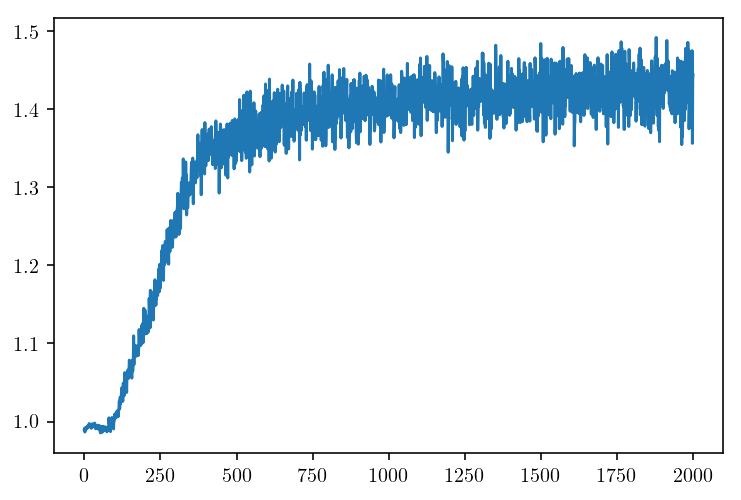

In [162]:
losses = []

for f, g in generate(2000):
    
    wasserstein.zero_grad()
    
    loss = wasserstein.loss(f, g)
    loss.backward()
    
    optimiser.step()
    
    losses.append(loss.item())
    
losses = np.array(losses)

plt.figure()
plt.plot(losses)
plt.show()

In [98]:
wasserstein(g)

tensor([[1.0000e+00],
        [9.9997e-01],
        [9.9992e-01],
        [7.0336e-05],
        [2.4912e-08],
        [3.4891e-06],
        [3.2362e-05],
        [1.5990e-01],
        [9.9999e-01],
        [4.9261e-04],
        [1.9040e-10],
        [1.0910e-09],
        [4.4363e-12],
        [5.4082e-03],
        [2.3508e-03],
        [1.0000e+00],
        [1.7395e-06],
        [3.0478e-09],
        [1.0477e-02],
        [9.9980e-01],
        [3.8609e-11],
        [1.0763e-03],
        [5.7274e-07],
        [6.2475e-10],
        [9.9911e-01],
        [1.0000e+00],
        [2.1539e-10],
        [7.0810e-04],
        [2.3391e-03],
        [9.9997e-01],
        [1.0000e+00],
        [9.7451e-08],
        [9.9932e-01],
        [1.1987e-09],
        [3.2237e-13],
        [3.3224e-11],
        [9.9999e-01],
        [1.0593e-08],
        [1.0000e+00],
        [4.7141e-08],
        [1.0000e+00],
        [9.9993e-01],
        [1.7910e-06],
        [5.1016e-06],
        [1.0083e-07],
        [5

In [51]:
js(g)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1